We're going to produce a Markov state model for a MD trajectory data set
States will be determined via spectral clustering in the 2-Wasserstein space,
and transition probabilities computed empirically

In [1]:
%%time
import sys
sys.path.append("../src")
import utils
import pandas as pd
import numpy as np
import ot
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx 
from sklearn.cluster import SpectralClustering

CPU times: user 3.37 s, sys: 958 ms, total: 4.33 s
Wall time: 4.97 s


Our data comes in as a csv with observations representing spatial location data

In [2]:
df = pd.read_csv("../data/Langevin_1D.txt", names=['x'])

for a given windowsize (to be determine algorithmicly elsewhere) we compute the 
wasserstein distance between neighboring distributions

In [3]:
def compute_wass_dists(data, windowsize):
    N = len(data)
    distances = np.zeros((N))
    for t in tqdm(range(windowsize, N - windowsize)):
        mu = data[t - windowsize:t].to_numpy()
        nu = data[t: t+windowsize].to_numpy()
        distances[t] = ot.emd2_1d(mu, nu)
    return distances

In [4]:
df['dists'] = compute_wass_dists(df,300)

100% 99400/99400 [00:31<00:00, 3151.27it/s]


we make our predictions of change points by identifying the points in time at which the wasserstein distance between neighboring distributions is greatest
because the instantaneous change in wasserstein distance (second derivative) may be small, we filter segments of rapid wasserstein change by taking the maximal point

In [5]:
def filter_change_points(
    differences: np.ndarray,
    change_points: np.ndarray,
) -> np.ndarray:
    # find the boundaries of the regions containing consecutive CP candidates
    boundary_pts = []
    for i in range(len(change_points) - 1):
        if change_points[i + 1] - change_points[i] > 1:
            boundary_pts.append(change_points[i])
            boundary_pts.append(change_points[i + 1])  
    boundary_pts.append(len(differences))

    # filter for and output the final change points
    filtered_points = []
    for i in range(len(boundary_pts) - 1):
        lo = boundary_pts[i]
        hi = boundary_pts[i + 1]
        #if hi - lo > 1:
        subset = differences[lo:hi]
        if type(subset) is not np.ndarray:
            subset = np.array(subset)
        filtered_points.append(subset.argmax() + lo)
    return np.array(boundary_pts)

In [6]:
distances = df['dists']
candidates = utils.identify_change_points(distances)
change_points = filter_change_points(distances,candidates) 
print(change_points)

[   520    927   1151   1278   1393   2425   2999   8109   8495  10381
  10570  10744  10932  11095  11514  11823  12215  15926  16152  16616
  16814  18128  18138  18355  18672  20215  20304  21268  21437  21870
  22212  24036  24431  25207  25590  26783  27002  27469  27790  27996
  28115  28396  28716  29415  29694  32012  32434  33778  34183  35700
  35861  36065  36333  39496  39543  39805  39948  41114  41226  41456
  41509  42883  43287  50531  50923  51387  51626  53649  53836  53843
  53858  54061  54306  57666  58051  58369  58769  59310  59740  62487
  62805  63340  63599  63778  64088  71074  71437  71801  72204  73452
  73526  73803  73893  80204  80405  84883  85359  85615  85954  87693
  88013  89300  89337  89595  89678  89955  90404  91253  91524  91754
  91902  96757 100000]


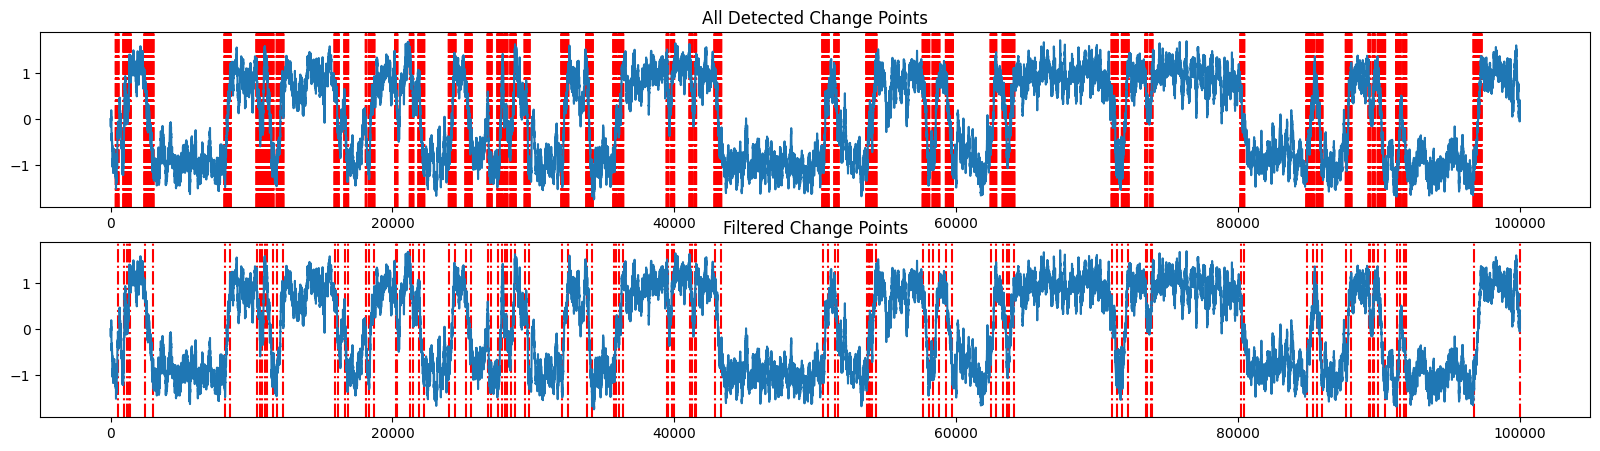

In [7]:
fig, (ax0, ax1) = plt.subplots(2,1)
fig.set_size_inches(20,5)
ax0.plot(df['x'])
ax1.plot(df['x'])
cutoff = np.quantile(df['dists'], 0.85)
for t in candidates:
    ax0.axvline(t, linestyle='dashdot', c='r', zorder=0)
for t in change_points:
    ax1.axvline(t, linestyle='dashdot', c='r', zorder=0)
ax0.set_title("All Detected Change Points")
ax1.set_title('Filtered Change Points')
plt.savefig('Langevin_change_points.pdf', bbox_inches='tight')

once we've identified change points, this partitions the time series into a series of states, which we consider to be distributions

In [8]:
def enumerate_states(data, column, cps):
    distributions = []
    num_states = len(cps)
    distributions.append(data[column][0:cps[0]].to_numpy())
    for i in range(num_states - 1):
        t0, t1 = cps[i], cps[i+1]
        mu = data[column][t0:t1].to_numpy()
        distributions.append(mu)
    return distributions

In [9]:
states = enumerate_states(df, 'x', change_points)

we form a matrix encoding the pairwise wasserstein distances between all states so identified via our cpd scheme

In [12]:
def compute_pairwise_dists(state_list):
    N = len(state_list)
    dist_mat = np.zeros((N,N))
    for i in tqdm(range(N)):
        mu = state_list[i]
        for j in range(i, N):
            nu = state_list[j]
            dist = ot.emd2_1d(mu, nu)
            dist_mat[i,j], dist_mat[j, i] = dist, dist
    return dist_mat

In [13]:
wasserstein_distance_matrix = compute_pairwise_dists(states)

100% 113/113 [00:02<00:00, 44.91it/s]


with the pairwise distance information in hand, we form a similarity matrix and perform off-the-shelf spectral clustering to identify clusters in 2-Wasserstein space. We compute the 2-Wasserstein barycenter of each cluster (actually a subset thereof) to get a canonical representation of the state to be associated with each cluster.

In [15]:
def filter_distributions(clustered_states, q=0.5):
    cluster_sizes = [len(state) for state in clustered_states]
    cutoff = np.quantile(cluster_sizes, q)
    distributions = []
    for state in clustered_states:
        if len(state) > cutoff:
            distributions.append(state)
    return distributions

def gaussian_kernel_similarity_graph(distances, sigma=1):
    return np.exp(-(distances ** 2) / sigma)

def compute_bar(states, reg=1e-2):
    ref_count = len(states)
    weights = ot.unif(ref_count)
    references = [np.array([states[i]]).T for i in range(len(states))]
    measure_weights = [ot.unif(len(state)) for state in states]
    bar_init = np.random.randn(100, 1)
    bar = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations = references,
        measures_weights = measure_weights,
        weights = weights,
        X_init = bar_init,
        reg = reg,
    )
    return bar

we form the gaussian kernel similarity matrix and call a spectral clustering method on it -- we provided an initial guess for the number of states

CPU times: user 3.14 s, sys: 354 ms, total: 3.49 s
Wall time: 2.11 s


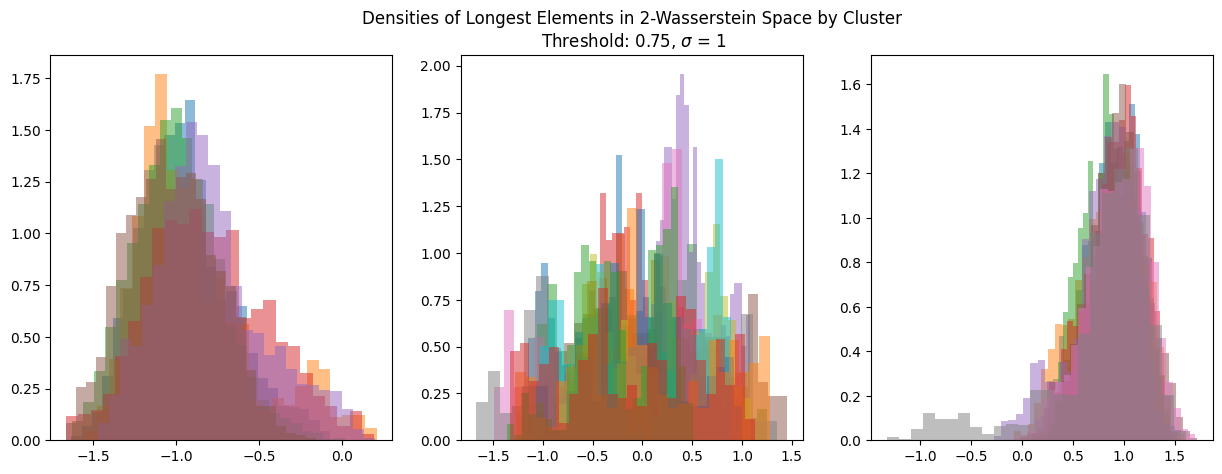

In [49]:
%%time
A = wasserstein_distance_matrix
sigma=1
B = gaussian_kernel_similarity_graph(wasserstein_distance_matrix, sigma=sigma)
state_num_guess = 3
cutoff = 0.75
sc = SpectralClustering(state_num_guess, affinity="precomputed")
sc.fit_predict(B)
labels = sc.labels_
unique_elements, counts = np.unique(labels, return_counts=True)
duplicate_elements = unique_elements[counts > 1]
indices = [np.where(labels == element)[0] for element in duplicate_elements]
clusters = [[states[i] for i in index_list] for index_list in indices]
cluster_sizes = [len(state) for state in clusters[0]]
filtered = [filter_distributions(cluster, cutoff) for cluster in clusters]
C = len(clusters)
fig, axes = plt.subplots(1,C)
fig.set_size_inches(15,5)
bins=25
for i in range(C):
    for state in filtered[i]:
        axes[i].hist(state, density=True, alpha=0.5, bins=bins)
axes[int(C / 2)].set_title(f"Densities of Longest Elements in 2-Wasserstein Space by Cluster\n Threshold: {cutoff}, " + r"$\sigma$ = " + f"{sigma}")
plt.savefig(f"clustered-densities-{cutoff}.pdf", bbox_inches='tight')

In [50]:
%%time
bars = [compute_bar(filtered[i], ) for i in range(len(filtered))]

/usr/local/lib/python3.11/site-packages/ot/bregman.py:504: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 14
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 79
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 19
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 70
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.11/site-packages/ot/bregman.py:511: UserWarning: Warning: numerical errors at iteration 69
  warnings.warn('Warning: numerical

CPU times: user 9min 52s, sys: 2min 6s, total: 11min 58s
Wall time: 3min 18s


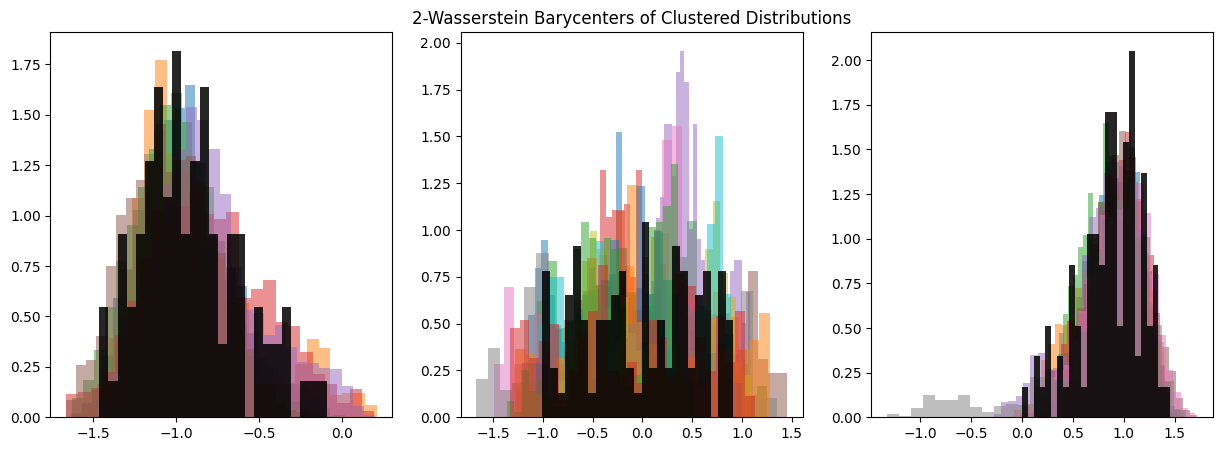

In [51]:
fig, axes = plt.subplots(1,C)
fig.set_size_inches(15,5)
for i in range(C):
    axes[i].hist(bars[i], color='black',zorder=50, density=True, alpha=0.85, bins=bins)
    for state in filtered[i]:
        axes[i].hist(state, density=True, alpha=0.5, bins=bins)
axes[int(C / 2)].set_title("2-Wasserstein Barycenters of Clustered Distributions")
plt.savefig("cluster-bars.pdf", bbox_inches='tight')

In [52]:
# use the barycenter to define the boundaries of states
# get the list of states by comparing the trajectory against the boundaries established in the prior step
# use the sequence of states to form a Markov chain
# output its steady state

In [53]:
%%time
#bar0 = compute_bar(filtered[0])
#bar1 = compute_bar(filtered[1])
#bar2 = compute_bar(filtered[2])


state_0_lo, state_0_center, state_0_hi = np.quantile(bars[0], 0.25), np.quantile(bars[0], 0.5), np.quantile(bars[0], 0.75)
state_1_lo, state_1_center, state_1_hi = np.quantile(bars[1], 0.25), np.quantile(bars[1], 0.5), np.quantile(bars[1], 0.75)
state_2_lo, state_2_center, state_2_hi = np.quantile(bars[2], 0.25), np.quantile(bars[2], 0.5), np.quantile(bars[2], 0.75)

CPU times: user 4.02 ms, sys: 3.64 ms, total: 7.66 ms
Wall time: 4.45 ms


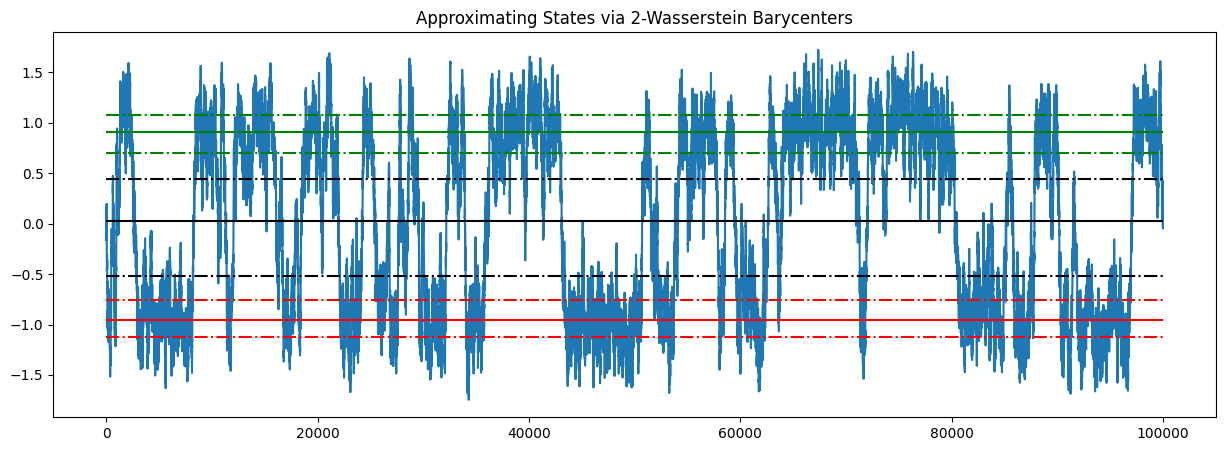

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax.plot(df['x'], alpha=0.8)
ax.hlines(state_0_lo, 0, 10e4, color='red', linestyle='dashdot')
ax.hlines(state_0_hi, 0, 10e4, color='red', linestyle='dashdot')
ax.hlines(state_0_center, 0, 10e4, color='red')

ax.hlines(state_1_center, 0, 10e4, color='black')
ax.hlines(state_1_lo, 0, 10e4, color='black', linestyle='dashdot')
ax.hlines(state_1_hi, 0, 10e4, color='black', linestyle='dashdot')

ax.hlines(state_2_lo, 0, 10e4, color='green', linestyle='dashdot')
ax.hlines(state_2_hi, 0, 10e4, color='green', linestyle='dashdot')
ax.hlines(state_2_center, 0, 10e4, color='green')
plt.title("Approximating States via 2-Wasserstein Barycenters")
plt.savefig("states-with-trajectory.pdf", bbox_inches='tight')

In [55]:
sc.labels_

array([0, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 0,
       1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2,
       1, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2,
       1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0,
       1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1,
       1, 0, 2], dtype=int32)

finally we form the markov chain from the labels found via the clustering

In [56]:
def markov_chain_from_labels(labels):
    num_obs = len(labels)
    states = np.unique(labels)
    num_states = len(states)
    chain = np.zeros((num_states, num_states))
    for t in range(num_obs - 1):
        chain[labels[t], labels[t + 1]] += 1
    for i in range(num_states):
        row  = chain[i, :]
        chain[i, :] = row / np.linalg.norm(row, 1)
    return chain
    
def find_markov_steady_state(p):
    dim = p.shape[0]
    q = p - np.eye(dim)
    ones = np.ones(dim)
    q = np.c_[q, ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dim)
    return np.linalg.solve(QTQ, bQT)

In [57]:
chain = markov_chain_from_labels(sc.labels_)
print(chain)
print(find_markov_steady_state(chain))

[[0.20833333 0.75       0.04166667]
 [0.32142857 0.30357143 0.375     ]
 [0.         0.65625    0.34375   ]]
[0.20268097 0.49919571 0.29812332]


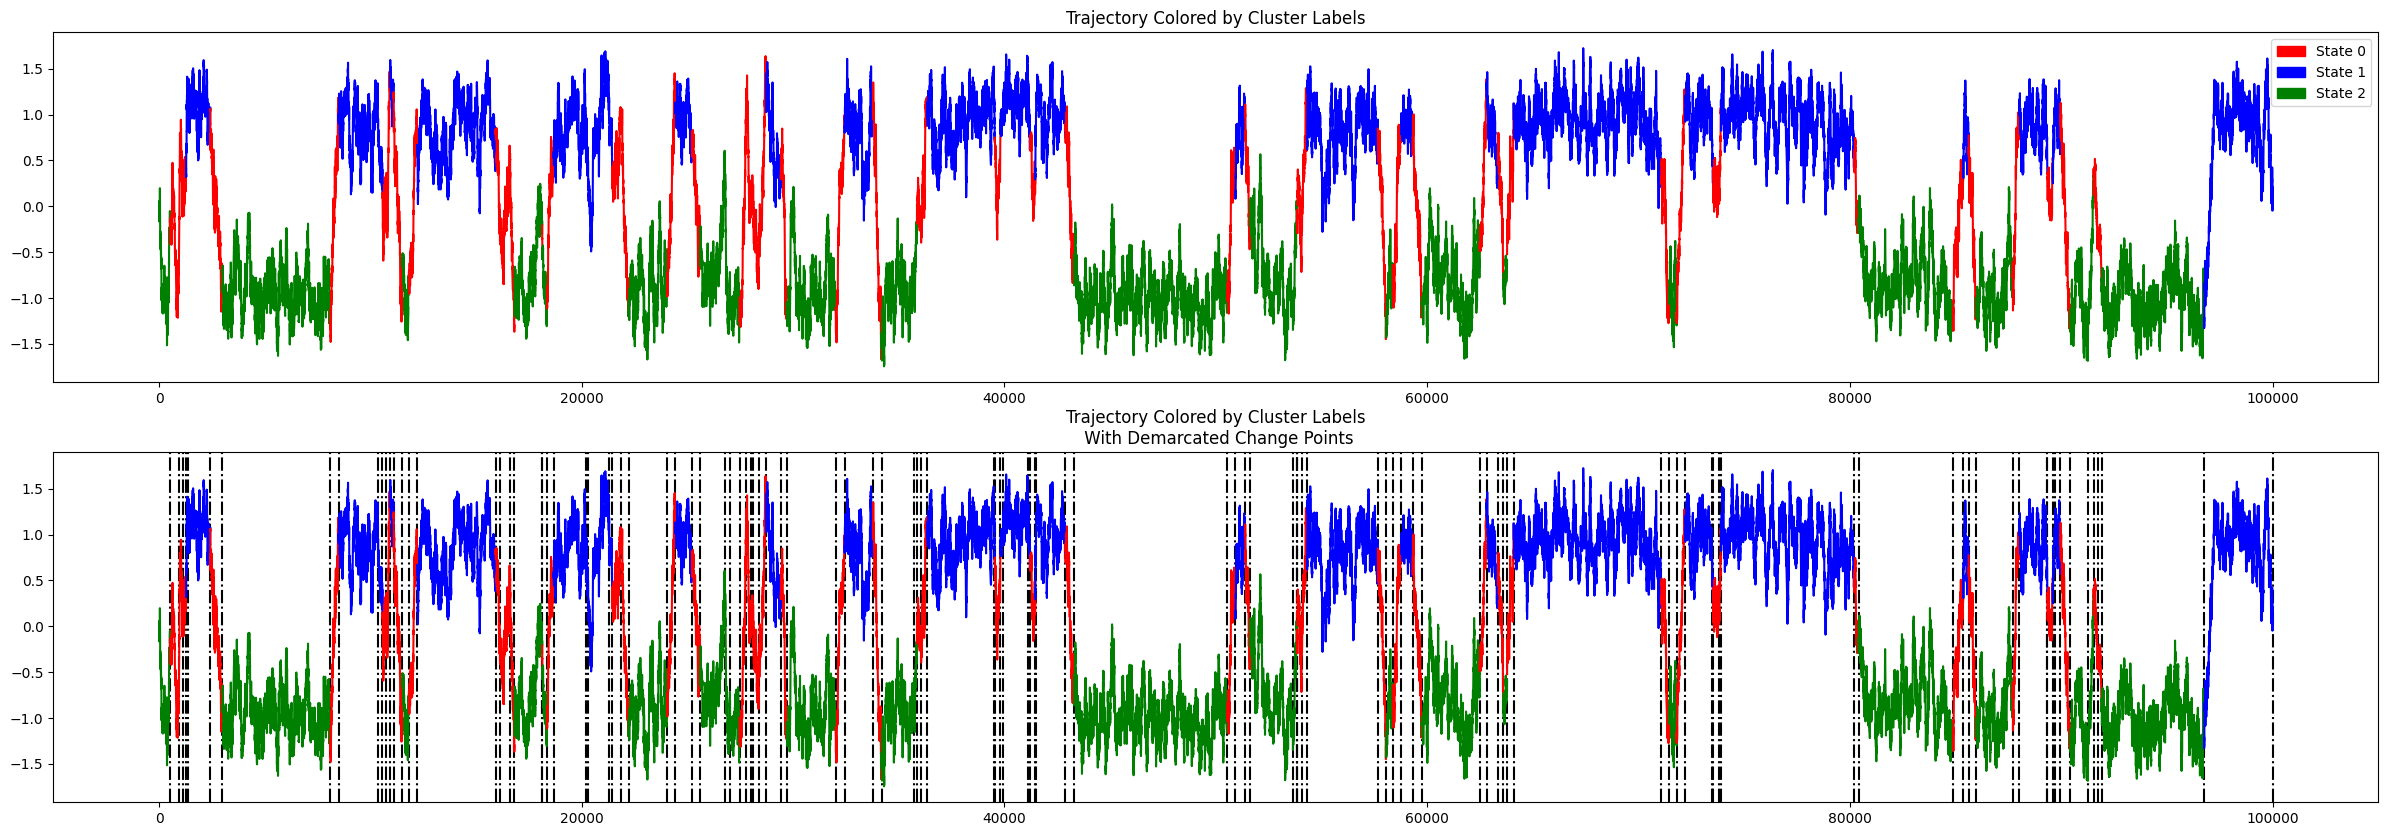

In [25]:
import matplotlib.patches as mpatches
fig, (ax0, ax1) = plt.subplots(2,1)
fig.set_size_inches(30,10)
t = 0
series = df['x']
labels = sc.labels_
#ax.plot(df['x'],c='purple',zorder=50,alpha=0.5)
for state, label in zip(states, labels):
    if label == 0:
        c = 'r'
    elif label == 1:
        c = 'b'
    else:
        c = 'g'
    l = len(state)
    t_dom = np.arange(t, t+l)
    ax0.plot(t_dom, series[t:t+l], c=c)
    ax1.plot(t_dom, series[t:t+l], c=c)
    t += l
for t in change_points:
    ax1.axvline(t, linestyle='dashdot', c='black', zorder=0)
red_patch = mpatches.Patch(color='red', label='State 0')
blue_patch = mpatches.Patch(color='blue', label='State 1')
green_patch = mpatches.Patch(color='green', label='State 2')
ax0.legend(handles=[red_patch, blue_patch, green_patch], loc='best')
ax0.set_title("Trajectory Colored by Cluster Labels")
ax1.set_title("Trajectory Colored by Cluster Labels\n With Demarcated Change Points")
plt.savefig("colored-trajs.pdf", bbox_inches='tight')